## ENKI Visualize and Compare Plots

[completed] Live demo of ENKI. 

### Prepare
Check environment. Install packages if in Colab.


In [1]:
""" :((( """
from dataclasses import replace
from datetime import datetime
import os, sys
import numpy as np
import scipy
from scipy import stats
from urllib.parse import urlparse
import datetime

import argparse

import healpy as hp

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Ellipse


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['font.family'] = 'stixgeneral'

import pandas as pd
import seaborn as sns

import h5py

from ulmo import plotting
from ulmo.utils import utils as utils

from ulmo import io as ulmo_io
from ulmo.ssl import single_image as ssl_simage
from ulmo.ssl import defs as ssl_defs
from ulmo.mae import patch_analysis
from ulmo.utils import image_utils

import sys
import os
import requests

import torch
import numpy as np
import h5py

import matplotlib.pyplot as plt
from PIL import Image
from ulmo.plotting import plotting

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

### Define utils

In [2]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 1
    _, cm = plotting.load_palette()
    #plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int(), cmap=cm)
    plt.imshow(image, cmap=cm)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_LLC_patch4'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model, mask_ratio):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask
    
    im = im_paste.cpu().detach().numpy()
    m = mask.cpu().detach().numpy()
    im = im.squeeze()
    m = m.squeeze()
    print(im.shape)
    print(m.shape)
    
    return im, m
    

In [3]:
def plot_recon(orig_img, recon_img, mask_img, idx,
               apply_bias=False, vmnx = [None, None, None, None],
               LL_file='MAE_LLC_valid_nonoise.parquet'):
    # Load Unmasked
    unmasked = 1 - mask_img

    # Bias
    diff_true = recon_img - orig_img
    bias = np.median(diff_true[np.abs(diff_true)>0.])

    # Find the patches
    p_sz = 4
    patches = patch_analysis.find_patches(mask_img, p_sz)
    upatches = patch_analysis.find_patches(unmasked, p_sz)


    fig = plt.figure(figsize=(9, 4))
    plt.clf()
    gs = gridspec.GridSpec(1,4)
    ax0 = plt.subplot(gs[0])

    _, cm = plotting.load_palette()
    cbar_kws={'label': 'SSTa (K)',
              'fraction': 0.0450,
              'location': 'top'}

    _ = sns.heatmap(np.flipud(orig_img), xticklabels=[],
                    vmin=vmnx[0], vmax=vmnx[1],
                    yticklabels=[], cmap=cm, cbar=True, 
                    square=True, 
                    cbar_kws=cbar_kws,
                    ax=ax0)

    # Reconstructed
    sub_recon = np.ones_like(recon_img) * np.nan
    # Difference
    diff = np.ones_like(recon_img) * np.nan
    frecon = recon_img.copy()

    # Plot/fill the patches
    for kk, patch in enumerate(patches):
        i, j = np.unravel_index(patch, mask_img.shape)
        
        # Fill
        sub_recon[i:i+p_sz, j:j+p_sz] = recon_img[i:i+p_sz, j:j+p_sz]
        frecon[i:i+p_sz, j:j+p_sz]
        # ???
        diff[i:i+p_sz, j:j+p_sz] = diff_true[i:i+p_sz, j:j+p_sz]
        if apply_bias:
            sub_recon[i:i+p_sz, j:j+p_sz] = recon_img[i:i+p_sz, j:j+p_sz] - bias
            frecon[i:i+p_sz, j:j+p_sz] -= bias
            # ???
            diff[i:i+p_sz, j:j+p_sz] = diff_true[i:i+p_sz, j:j+p_sz] - bias
        


    # Reconstructed
    usub_recon = np.ones_like(recon_img) * np.nan
    # Difference
    udiff = np.ones_like(recon_img) * np.nan
    ufrecon = recon_img.copy()

    # Plot/fill the patches
    for kk, patch in enumerate(upatches):
        i, j = np.unravel_index(patch, unmasked.shape)
        # Fill
        usub_recon[i:i+p_sz, j:j+p_sz] = orig_img[i:i+p_sz, j:j+p_sz]
        ufrecon[i:i+p_sz, j:j+p_sz]
        # ???
        udiff[i:i+p_sz, j:j+p_sz] = diff_true[i:i+p_sz, j:j+p_sz]

    # Unmasked image
    ax1 = plt.subplot(gs[1])

    u_recon = False
    if u_recon:
        usub_recon = ufrecon.copy()
    _ = sns.heatmap(np.flipud(usub_recon), xticklabels=[],
                    vmin=vmnx[0], vmax=vmnx[1],
                    yticklabels=[], cmap=cm, cbar=True, 
                    square=True, cbar_kws=cbar_kws,
                    ax=ax1)

    # Recon image
    ax2 = plt.subplot(gs[2])

    full_recon = True
    if apply_bias:
        cbar_kws['label'] = 'SSTa (K) ({:.3f} bias)'.format(bias)
    if full_recon:
        sub_recon = frecon.copy()
    _ = sns.heatmap(np.flipud(sub_recon), xticklabels=[],
                    vmin=vmnx[0], vmax=vmnx[1],
                    yticklabels=[], cmap=cm, cbar=True, 
                    square=True, cbar_kws=cbar_kws,
                    ax=ax2)

    # Residual image
    ax3 = plt.subplot(gs[3])

    cbar_kws['label'] = 'Residuals (K)'
    _ = sns.heatmap(np.flipud(diff), xticklabels=[], 
                    vmin=vmnx[2], vmax=vmnx[3],
                    yticklabels=[], cmap='bwr', cbar=True,
                    square=True, 
                    cbar_kws=cbar_kws,
                    ax=ax3)

    # Borders
    # 
    for ax, title in zip( [ax0, ax1, ax2 ,ax3],
        ['Original', 'Unmasked', 'Reconstructed', 'Residuals']):
        ax.patch.set_edgecolor('black')  
        ax.patch.set_linewidth(1.)  
        #
        show_title=True
        if show_title:
            ax.set_title(title, fontsize=14, y=-0.13)
    
    # Plot title
    table = pd.read_parquet(LL_file, engine='pyarrow',columns=['pp_idx', 'LL'])
    table = table[table['LL'].notna()]
    table = table.sort_values(by=['pp_idx'])
    LL = int(table.iloc[idx]['LL'])
    #fig.suptitle('{LL} LL Reconstruction: t{model} {p}% masking'.format(LL=LL))
    fig.suptitle('{LL} LL Reconstruction'.format(LL=LL))
    
    plt.tight_layout(pad=0.5, h_pad=0.5, w_pad=0.5)
    #outfile = 'corner_example.png'
    #plt.savefig(outfile, dpi=300)
    #plt.close()
    #print('Wrote {:s}'.format(outfile))

### Load a pre-trained MAE model

In [4]:
# Models:
t10_file = 'data/ENKI_t10.pth'
t35_file = 'data/ENKI_t35.pth'
t50_file = 'data/ENKI_t50.pth'
t75_file = 'data/ENKI_t75.pth'

In [5]:
# load model trained on 10% masking
model_mae_35 = prepare_model(t35_file, 'mae_vit_LLC_patch4')
print('Model10 loaded.')

<All keys matched successfully>
Model10 loaded.


In [6]:
# load model trained on 10% masking
model_mae_10 = prepare_model(t10_file, 'mae_vit_LLC_patch4')
print('Model10 loaded.')

<All keys matched successfully>
Model10 loaded.


In [7]:
# load model trained on 50% masking
model_mae_50 = prepare_model(t50_file, 'mae_vit_LLC_patch4')
print('Model50 loaded.')

<All keys matched successfully>
Model50 loaded.


In [8]:
# load model trained on 75% masking
model_mae_75 = prepare_model(t75_file, 'mae_vit_LLC_patch4')
print('Model75 loaded.')

<All keys matched successfully>
Model75 loaded.


### Load an image

(655788, 1, 64, 64)
(64, 64, 1)


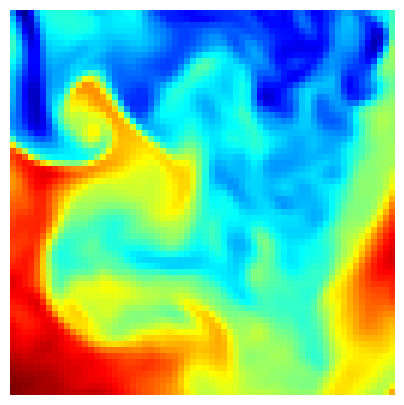

In [9]:
# load an image
filepath = 'data/MAE_LLC_valid_nonoise_preproc.h5'
idx = 330469
#idx = 92810
idx = 2365
# idx = 666 # good for capturing blurriness in reconstructions
with h5py.File(filepath, 'r') as f:
    print(f['valid'].shape)
    img = f['valid'][idx][0]
img.resize((64,64,1))
assert img.shape == (64, 64, 1)

print(img.shape)
_, cm = plotting.load_palette()
plt.rcParams['figure.figsize'] = [5, 5]
show_image(torch.tensor(img))

### Run MAE on the image

In [10]:
# make random mask reproducible (comment out to make it change)
group1 = [209248, 524321, 414040, 610138]
group2 = [245215, 72480, 29518, 569580] 
group3 = [313043, 202716, 15385, 478432] 
group4 = [173629, 426310, 599472, 595621]


indexes = [209248, 524321, 414040, 610138, 245215, 72480, 29518, 569580, 
           313043, 202716, 15385, 478432, 173629, 426310, 599472, 595621]
f = h5py.File(filepath, 'r')

models = [model_mae_10, model_mae_35, model_mae_50, model_mae_75]
mask_ratios = [0.10, 0.35, 0.50, 0.75]

orig_imgs = []
recon_imgs = []
masks = []

for (idx, t, p) in zip(group1, models, mask_ratios):
    orig_img = f['valid'][idx][0]
    orig_img.resize((64,64,1))
    recon_img, mask = run_one_image(orig_img, t, p)
    orig_img = orig_img.squeeze()
    orig_imgs.append(orig_img)
    recon_imgs.append(recon_img)
    masks.append(mask)
    
for (idx, t, p) in zip(group2, models, mask_ratios):
    orig_img = f['valid'][idx][0]
    orig_img.resize((64,64,1))
    recon_img, mask = run_one_image(orig_img, t, p)
    orig_img = orig_img.squeeze()
    orig_imgs.append(orig_img)
    recon_imgs.append(recon_img)
    masks.append(mask)
    
for (idx, t, p) in zip(group3, models, mask_ratios):
    orig_img = f['valid'][idx][0]
    orig_img.resize((64,64,1))
    recon_img, mask = run_one_image(orig_img, t, p)
    orig_img = orig_img.squeeze()
    orig_imgs.append(orig_img)
    recon_imgs.append(recon_img)
    masks.append(mask)
    
for (idx, t, p) in zip(group4, models, mask_ratios):
    orig_img = f['valid'][idx][0]
    orig_img.resize((64,64,1))
    recon_img, mask = run_one_image(orig_img, t, p)
    orig_img = orig_img.squeeze()
    orig_imgs.append(orig_img)
    recon_imgs.append(recon_img)
    masks.append(mask)


(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)
(64, 64)


In [11]:
orig_imgs = np.array(orig_imgs)
recon_imgs = np.array(recon_imgs)
masks = np.array(masks)

In [12]:
#masks = [p10_mask[0], p30_mask[0], p50_mask]
np.savez('gallery_imgs.npz', orig_imgs=orig_imgs, recon_imgs=recon_imgs, masks=masks)